# Set up

In [58]:
## prepare packages
#%pip install -U pandas
#%pip install -U matplotlib
#%pip install -U gensim
#%pip install -U scipy
#%pip install -U pyLDAvis
#%pip install -U plotly
#%pip install -U 'nbformat>=4.2.0'

In [59]:
## import modules
import os, sys
## maake accessible files on level immediately above 
sys.path.append(os.path.join(os.path.dirname("__file__"), ".."))
## import other modules
import re
import gzip, glob
import unicodedata

# Preparation 1

In [60]:
## parameters
verbose              = True
save_results         = False
targets_csv          = True

## source sampling
source_sampling      = True
source_sampling_rate = 0.03 # optimal values depend on kinds of source

## doc settings # The longer sentences become, the less precise pairing becomes
size_measures        = [ 'sp_size', 'sn_size' ]
size_measure         = size_measures[1]
max_doc_size         = 10 # values larger than 10 take considerably longer to complete
min_doc_size         =  4

## preprocessing settings
lower_chars          = True
strip_accents        = True
add_boundaries       = True
boundary_symbol      = '#'  # requires more processing resource
if add_boundaries:
    hash_status = "-hashed"
else:
    hash_status = ""

## term settings
ngram_is_inclusive    = True # takes significantly more time to complete but invites sum error if False with larger n, 
inclusion_degree      = 1    # Valid values are {0, 1, 2, ..., None}. With k, n-grams includes (n-k)-grams
max_gap_size_factor   = 0.53 # It takes time at valuers larger than 0.5 with larger n such as n = 5
max_gap_size          = round(max_doc_size * max_gap_size_factor) # This needs to be smaller than other cases.

## Skippy n-gram の隙間を表わす記号
gap_marker            = "…"

## spell term と sound term の連結記号
pair_marker           = " :: "

## set spell term_type
sp_term_types  = [ 'sp_1gram',
                  'sp_2gram', 'sp_3gram', 'sp_4gram', 'sp_5gram',
                 'sp_sk2gram', 'sp_sk3gram', 'sp_sk4gram', 'sp_sk5gram' ]
sp_term_type   = sp_term_types[-1]
print(f"sp_term_type: {sp_term_type}")

## set sound term_type
sn_term_types = [ 'sn_1gram',
                 'sn_2gram', 'sn_3gram', 'sn_4gram', 'sn_5gram',
                 'sn_sk2gram', 'sn_sk3gram', 'sn_sk4gram', 'sn_sk5gram' ]
sn_term_type = sn_term_types[-1]
print(f"sn_term_type: {sn_term_type}")

sp_term_type: sp_sk5gram
sn_term_type: sn_sk5gram


In [61]:
## term filtering: some combinations cause "Not all rows sum to 1" error with HDP, but no with LDA
apply_term_freq_filtering  = True
term_minfreq               = 3 # Effective for speeding up
apply_term_abuse_filtering = True
term_abuse_threshold       = 0.1 # Larger values reveal deeper; 0.006 seems to be the smallest

In [62]:
## select HDP or LDA: HDP takes considerably longer than LDA,
## and is susceptible with "Not all rows sum to 1" error at pyLDAvis
## HDP
use_HDP         = True
max_n_topics    = 45
n_terms_to_show = 120

## LDA
n_topics  = max_n_topics # 精度にはあまり影響しない？
if use_HDP:
    method_name  = "HDP" # non-executive variable to be used in file names
else:
    method_name  = "LDA"

## tSNE
top_perplexity_reduct_rate = 0.33
##
print(f"method_name: {method_name}")
print(f"max_n_topics for HDP: {max_n_topics}")
print(f"n_topics for LDA: {n_topics}")
print(f"top_perplexity_reduct_rate: {top_perplexity_reduct_rate}")

method_name: HDP
max_n_topics for HDP: 45
n_topics for LDA: 45
top_perplexity_reduct_rate: 0.33


In [63]:
## get data
import glob
data_dir1 = "data/open-dict-ipa/data1"
data_dir2 = "data/open-dict-ipa/data1a"
files = [ ]
for dir in [ data_dir1, data_dir2 ]:
    gz_files = glob.glob(f"{dir}/*.gz")
    files.extend(gz_files)
    csv_files = glob.glob(f"{dir}/*.csv")
    files.extend(csv_files)
    txt_files = glob.glob(f"{data_dir2}/*.txt")
    files.extend(txt_files)
#
files

['data/open-dict-ipa/data1/yue.csv.gz',
 'data/open-dict-ipa/data1/vi_S.csv.gz',
 'data/open-dict-ipa/data1/de.csv.gz',
 'data/open-dict-ipa/data1/jam.csv.gz',
 'data/open-dict-ipa/data1/fa.csv.gz',
 'data/open-dict-ipa/data1/zh_hant.csv.gz',
 'data/open-dict-ipa/data1/sw.csv.gz',
 'data/open-dict-ipa/data1/ar.csv.gz',
 'data/open-dict-ipa/data1/es_MX.csv.gz',
 'data/open-dict-ipa/data1/vi_C.csv.gz',
 'data/open-dict-ipa/data1/ma.csv.gz',
 'data/open-dict-ipa/data1/fi.csv.gz',
 'data/open-dict-ipa/data1/eo.csv.gz',
 'data/open-dict-ipa/data1/fr_QC.csv.gz',
 'data/open-dict-ipa/data1/es_ES.csv.gz',
 'data/open-dict-ipa/data1/en_US.csv.gz',
 'data/open-dict-ipa/data1/en_UK.csv.gz',
 'data/open-dict-ipa/data1/nb.csv.gz',
 'data/open-dict-ipa/data1/nl.csv.gz',
 'data/open-dict-ipa/data1/sv.csv.gz',
 'data/open-dict-ipa/data1/or.csv.gz',
 'data/open-dict-ipa/data1/zh_hans.csv.gz',
 'data/open-dict-ipa/data1/fr_FR.csv.gz',
 'data/open-dict-ipa/data1/vi_N.csv.gz',
 'data/open-dict-ipa/data1/j

In [64]:
## select language and file
lang_names = {  'ar' : 'Arabic',
                'de' : 'German',
                'en' : 'English',
                'es' : 'Spanish',
                'fr' : 'French',
                'sw' : 'Swahili'
            }
#
lang_keys = [ 'ar', 'de', 'en', 'es', 'fr', 'sw' ]
#
lang_key  = lang_keys[2]
lang_name = lang_names[lang_key]
lang_attr = ""
print(f"lang_name: {lang_name} ({lang_attr}) [lang_key: {lang_key}]")
# aliases
target_lang_dict = lang_names
target_lang_keys = lang_keys
target_lang_key  = lang_key
target_lang_attr = lang_attr
#
files = [ file for file in files if f"/{lang_key}" in file ]
print(files)
if len(lang_attr) > 0:
    print(f"lang_attr: {lang_attr}")
    selected_files = [ file for file in files if lang_attr in file ]
else:
    selected_files = files
selected_files
if len(selected_files) == 0:
    exit()

lang_name: English () [lang_key: en]
['data/open-dict-ipa/data1/en_US.csv.gz', 'data/open-dict-ipa/data1/en_UK.csv.gz']


In [65]:
## build data from files
import re, unicodedata
import pandas as pd
check = False
target_file = selected_files[0]
col_names = [ 'sp_word', 'sn_word' ]
if target_file.endswith(".gz"):
    with gzip.open(target_file, "rt") as f:
        raw_df = pd.read_csv(f, encoding = 'utf8', header = None, names = col_names )
else:
    with open(target_file, "rt") as f:
        raw_df = pd.read_csv(f, encoding = 'utf8', header = None, names = col_names )
#
raw_df

,sp_word,sn_word
0,'bout,/ˈbaʊt/
1,'cause,/kəz/
2,'course,/ˈkɔɹs/
3,'cuse,/ˈkjuz/
4,'em,/əm/
...,...,...
125922,zysk,/ˈzaɪsk/
125923,zyskowski,/zɪˈskɔfski/
125924,zyuganov,"/ˈzjuɡɑnɑv/, /ˈzuɡɑnɑv/"
125925,zyuganov's,"/ˈzjuɡɑnɑvz/, /ˈzuɡɑnɑvz/"


In [66]:
## modify spell
raw_df['sp_word'] = raw_df['sp_word'].apply(lambda x: unicodedata.normalize('NFC', str(x)))
if lower_chars:
    raw_df['sp_word'] = raw_df['sp_word'].apply(lambda x: x.lower())

## modify sound symbols
raw_df['sn_word'] = raw_df['sn_word'].apply(lambda x: unicodedata.normalize('NFC', str(x)))
raw_df['sn_word'] = raw_df['sn_word'].apply(lambda x: re.sub(r"/", "", x))
raw_df['sn_word'] = raw_df['sn_word'].apply(lambda x: x.split(",")[0]) # pick up only the first
if strip_accents:
    raw_df['sn_word'] = raw_df['sn_word'].apply(lambda x: re.sub(r'"', "", x))
    raw_df['sn_word'] = raw_df['sn_word'].apply(lambda x: re.sub(r"[ˈˌ]", "", x))
#
raw_df

,sp_word,sn_word
0,'bout,baʊt
1,'cause,kəz
2,'course,kɔɹs
3,'cuse,kjuz
4,'em,əm
...,...,...
125922,zysk,zaɪsk
125923,zyskowski,zɪskɔfski
125924,zyuganov,zjuɡɑnɑv
125925,zyuganov's,zjuɡɑnɑvz


In [67]:
## build df
dids = [ ]
sids = [ ]
Spells = [ ]
Sounds = [ ]
for i, row in raw_df.iterrows():
    spell = row['sp_word']
    sound = row['sn_word']
    if len(spell) > 0 and len(sound) > 0:
        dids.append(i + 1)
        sids.append(i + 1)
        Spells.append(spell)
        Sounds.append(sound)
#
var_names = [ 'did', 'sid', 'sp_word', 'sn_word',
            'sp_size', 'sn_size', 'paired_terms', 
            'sp_1gram', 'sp_2gram', 'sp_3gram',
            'sp_sk2gram', 'sp_sk3gram',
            'sn_1gram', 'sn_2gram', 'sn_3gram', 
            'sn_sk2gram', 'sn_sk3gram' ]
df = pd.DataFrame()
df['did'] = dids
df['sid'] = sids
df['sp_word'] = Spells
df['sn_word'] = Sounds
#
df[var_names[:4]]

,did,sid,sp_word,sn_word
0,1,1,'bout,baʊt
1,2,2,'cause,kəz
2,3,3,'course,kɔɹs
3,4,4,'cuse,kjuz
4,5,5,'em,əm
...,...,...,...,...
125922,125923,125923,zysk,zaɪsk
125923,125924,125924,zyskowski,zɪskɔfski
125924,125925,125925,zyuganov,zjuɡɑnɑv
125925,125926,125926,zyuganov's,zjuɡɑnɑvz


In [68]:
## sampling
if source_sampling:
    original_size = len(df)
    sample_size = round(len(df) * source_sampling_rate)
    df = df.sample(sample_size)
    print(f"sampled {len(df)} ({source_sampling_rate:0.3f}) rows by discarding {original_size - len(df)} rows")

sampled 3778 (0.030) rows by discarding 122149 rows


In [69]:
## tokenization
import gzip, re
import pandas as pd
check = False
Snx = [ ]
Spx = [ ]
for i, row in df.iterrows():
    Spt = row['sp_word']
    Snt = row['sn_word']
    split_pattern = r""
    ## Spell
    sp_seg = [ x for x in re.split(split_pattern, Spt) if len(x) > 0 ]
    if check:
        print(sp_seg)
    Spx.append(sp_seg)
    ## Sound
    sn_seg = [ x for x in re.split(split_pattern, Snt) if len(x) > 0 ]
    if check:
        print(sn_seg)
    Snx.append(sn_seg)
## Spell
try:
    df['sp_1gram'] = Spx
except ValueError:
    pass
## Sound
try:
    df['sn_1gram'] = Snx
except ValueError:
    pass
## check result
if verbose:
    df

In [70]:
## add size columns
df['sp_size'] = df['sp_1gram'].apply(lambda x: len(x))
df['sn_size'] = df['sn_1gram'].apply(lambda x: len(x))
if verbose:
    df

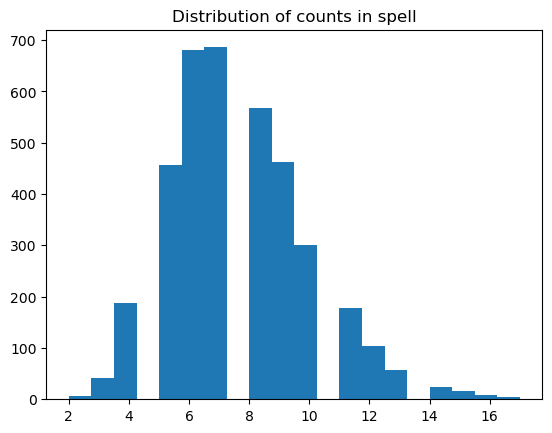

In [71]:
## 語の綴り文字数の分布
import matplotlib.pyplot as plt
plt.hist(df['sp_size'], bins = 20)
plt.title(f"Distribution of counts in spell")
plt.show()

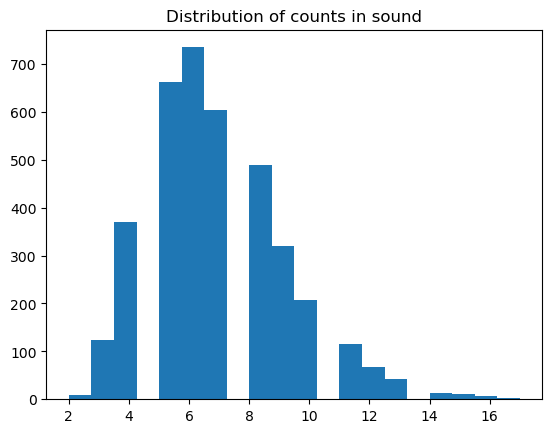

In [72]:
## 語の発音記号数の分布
import matplotlib.pyplot as plt
plt.hist(df['sn_size'], bins = 20)
plt.title(f"Distribution of counts in sound")
plt.show()

# build terms, part 1

In [73]:
## 長さで濾過
original_size = len(df)
print(f"discarding pairs whose {size_measure} part has less than {min_doc_size} chars")
df = df[df[size_measure] >= min_doc_size]

print(f"discarding pairs whose {size_measure} part has more than {max_doc_size} chars")
df = df[df[size_measure] < max_doc_size]

current_size = len(df)
size_diff = original_size - current_size
print(f"{size_diff} ({size_diff/original_size:.3f}) pairs were removed")
print(f"{current_size} pairs remain")

discarding pairs whose sn_size part has less than 4 chars
discarding pairs whose sn_size part has more than 10 chars
597 (0.158) pairs were removed
3181 pairs remain


In [74]:
## add boundaries
if add_boundaries:
    df['sp_word'] = df['sp_word'].apply(lambda x: f"{boundary_symbol}{x}{boundary_symbol}")
    df['sn_word'] = df['sn_word'].apply(lambda x: f"{boundary_symbol}{x}{boundary_symbol}")
    df[['sp_word', 'sn_word']]

In [75]:
## add 1gram
import re
w_splitter = r""
df['sp_1gram'] = [ [ x for x in re.split(w_splitter, w) if len(x) > 0 ] for w in df['sp_word'] ]
df['sn_1gram'] = [ [ x for x in re.split(w_splitter, w) if len(x) > 0 ] for w in df['sn_word'] ]
df[['sp_1gram', 'sn_1gram']]

,sp_1gram,sn_1gram
26523,"[#, d, a, l, o, i, a, #]","[#, d, ɑ, ɫ, o, ʊ, j, ə, #]"
78055,"[#, n, e, u, m, a, n, #]","[#, n, u, m, ə, n, #]"
77269,"[#, n, a, r, l, y, #]","[#, n, ɑ, ɹ, ɫ, i, #]"
40747,"[#, f, o, r, b, e, s, ', s, #]","[#, f, ɔ, ɹ, b, z, ɪ, z, #]"
110595,"[#, s, w, e, a, t, s, h, o, p, #]","[#, s, w, ɛ, t, ʃ, ɑ, p, #]"
...,...,...
92443,"[#, r, e, c, e, i, v, e, r, s, #]","[#, ɹ, ə, s, i, v, ɝ, z, #]"
58650,"[#, k, a, e, h, l, e, r, #]","[#, k, ɛ, ɫ, ɝ, #]"
7278,"[#, b, a, i, l, i, f, f, s, #]","[#, b, e, ɪ, ɫ, ə, f, s, #]"
75784,"[#, m, o, r, t, g, a, g, e, #]","[#, m, ɔ, ɹ, ɡ, ə, d, ʒ, #]"


In [76]:
## inspect frequent tokens in sp_1gram
from collections import Counter
sp_chars_all = [ ] 
[ sp_chars_all.extend(list(x)) for x in df['sp_1gram'] ]
sp_char_freqs = Counter(sp_chars_all)
## Show most frequent 10 segments
sｐ_char_freqs.most_common(10)

[('#', 6362),
 ('e', 2569),
 ('a', 1973),
 ('r', 1790),
 ('s', 1764),
 ('i', 1551),
 ('n', 1527),
 ('o', 1389),
 ('l', 1315),
 ('t', 1199)]

In [77]:
## inspect frequent tokens in sn_1gram
from collections import Counter
sn_chars_all = [ ] 
[ sn_chars_all.extend(list(x)) for x in df['sn_1gram'] ]
sn_char_freqs = Counter(sn_chars_all)
## Show most frequent 10 segments
sn_char_freqs.most_common(10)

[('#', 6362),
 ('ɪ', 1565),
 ('ə', 1458),
 ('n', 1261),
 ('s', 1144),
 ('ɫ', 1142),
 ('t', 1097),
 ('ɹ', 1079),
 ('k', 989),
 ('d', 833)]

In [78]:
## Install nltk if necessary
#!pip install -U nltk

n-grams の構築

In [79]:
def gen_ngrams_from_str(t: str, n: int, sep: str = r"", joint: str = "", check = False):
    'returns the list of character n-grams from a given string'
    import re
    segs = [ x for x in re.split(sep, t) if len(x) > 0 ]
    if check:
        print(segs)
    ## short input
    if len(segs) <= n:
        return segs
    ## long enough input
    G = [ ]
    for i in range(len(segs)):
        try:
            b = segs[ i : i + n ]
            if check:
                print(b)
            c = joint.join(b)
            if check:
                print(c)
            if len(c) == n:
                G.append(c)
        except IndexError:
            pass
    return G

In [80]:
## generic n-gram generation function
def add_ngrams(dfx, n_for_ngram: int, prefix: str = "", skippy: bool = False, skippiness_symbol: str = "sk", max_distance = None, seg_joint: str = "", gap_mark: str = "…", inclusive: bool = True, inclusion_degree = None, check: bool = False):
    "add ngram col to the dfx given"
    import gen_ngrams
    ## set variable names
    source_var_name = f"{prefix}1gram"
    if skippy:
        target_var_name  = f"{prefix}{skippiness_symbol}{n_for_ngram}gram"
        if n_for_ngram == 2:
            sub_var_name = f"{prefix}{n_for_ngram - 1}gram"
        else:
            sub_var_name = f"{prefix}{skippiness_symbol}{n_for_ngram - 1}gram"
            
    else:
        target_var_name  = f"{prefix}{n_for_ngram}gram"
        sub_var_name     = f"{prefix}{n_for_ngram - 1}gram"
    if check:
        print(f"source_var_name: {source_var_name}")
        print(f"target_var_name: {target_var_name}")
        print(f"sub_var_name: {sub_var_name}")
        
    ## 1gram
    unigrams = dfx[source_var_name]
    
    ## ngram
    if skippy:
        ngrams = [ gen_ngrams.gen_skippy_ngrams(g, n = n_for_ngram, sep = seg_joint, missing_mark = gap_mark, max_distance = max_distance, check = check) for g in unigrams ]
    else:
        ngrams = [ gen_ngrams.gen_ngrams(g, n = n_for_ngram, sep = seg_joint, check = check) for g in unigrams ]
    
    ## make ngrams inclusive
    if inclusive:
        sub_ngrams = list(dfx[sub_var_name])
        if inclusion_degree is None:
            for i, gram in enumerate(ngrams):
                assert len(ngrams) == len(sub_ngrams)
                supplement = sub_ngrams[i]
                supplement = [ g for g in supplement if len(g) > 0 ]
                if len(supplement) > 0:
                    gram.extend(supplement)
        else:
            min_size = (n_for_ngram - inclusion_degree)
            assert min_size >= 0
            for i, gram in enumerate(ngrams):
                assert len(ngrams) == len(sub_ngrams)
                supplement = sub_ngrams[i]
                supplement = [ g for g in supplement if len(g) >= min_size ]
                if len(supplement) > 0:
                    gram.extend(supplement)
    ## update df
    dfx[target_var_name] = ngrams
    print(dfx[target_var_name])

# Spell n-grams 生成

In [81]:
## sp_2gram の追加
add_ngrams(df, n_for_ngram = 2, prefix = "sp_", skippy = False, inclusive = True, inclusion_degree = inclusion_degree, check = False)

26523     [#d, da, al, lo, oi, ia, a#, #, d, a, l, o, i,...
78055     [#n, ne, eu, um, ma, an, n#, #, n, e, u, m, a,...
77269         [#n, na, ar, rl, ly, y#, #, n, a, r, l, y, #]
40747     [#f, fo, or, rb, be, es, s', 's, s#, #, f, o, ...
110595    [#s, sw, we, ea, at, ts, sh, ho, op, p#, #, s,...
                                ...                        
92443     [#r, re, ec, ce, ei, iv, ve, er, rs, s#, #, r,...
58650     [#k, ka, ae, eh, hl, le, er, r#, #, k, a, e, h...
7278      [#b, ba, ai, il, li, if, ff, fs, s#, #, b, a, ...
75784     [#m, mo, or, rt, tg, ga, ag, ge, e#, #, m, o, ...
19678     [#c, ch, hi, il, ld, dr, re, en, ns, s#, #, c,...
Name: sp_2gram, Length: 3181, dtype: object


In [82]:
## sp_3gram の追加
add_ngrams(df, n_for_ngram = 3, prefix = "sp_", skippy = False, inclusive = True, inclusion_degree = inclusion_degree, check = False)

26523     [#da, dal, alo, loi, oia, ia#, #d, da, al, lo,...
78055     [#ne, neu, eum, uma, man, an#, #n, ne, eu, um,...
77269     [#na, nar, arl, rly, ly#, #n, na, ar, rl, ly, y#]
40747     [#fo, for, orb, rbe, bes, es', s's, 's#, #f, f...
110595    [#sw, swe, wea, eat, ats, tsh, sho, hop, op#, ...
                                ...                        
92443     [#re, rec, ece, cei, eiv, ive, ver, ers, rs#, ...
58650     [#ka, kae, aeh, ehl, hle, ler, er#, #k, ka, ae...
7278      [#ba, bai, ail, ili, lif, iff, ffs, fs#, #b, b...
75784     [#mo, mor, ort, rtg, tga, gag, age, ge#, #m, m...
19678     [#ch, chi, hil, ild, ldr, dre, ren, ens, ns#, ...
Name: sp_3gram, Length: 3181, dtype: object


In [83]:
## sp_4gram の追加
add_ngrams(df, n_for_ngram = 4, prefix = "sp_", skippy = False, inclusive = True, inclusion_degree = inclusion_degree, check = False)

26523     [#dal, dalo, aloi, loia, oia#, #da, dal, alo, ...
78055     [#neu, neum, euma, uman, man#, #ne, neu, eum, ...
77269     [#nar, narl, arly, rly#, #na, nar, arl, rly, ly#]
40747     [#for, forb, orbe, rbes, bes', es's, s's#, #fo...
110595    [#swe, swea, weat, eats, atsh, tsho, shop, hop...
                                ...                        
92443     [#rec, rece, ecei, ceiv, eive, iver, vers, ers...
58650     [#kae, kaeh, aehl, ehle, hler, ler#, #ka, kae,...
7278      [#bai, bail, aili, ilif, liff, iffs, ffs#, #ba...
75784     [#mor, mort, ortg, rtga, tgag, gage, age#, #mo...
19678     [#chi, chil, hild, ildr, ldre, dren, rens, ens...
Name: sp_4gram, Length: 3181, dtype: object


In [84]:
## sp_5gram の追加
if "5gram" in sp_term_type:
    add_ngrams(df, n_for_ngram = 5, prefix = "sp_", skippy = False, inclusive = True, inclusion_degree = inclusion_degree, check = False)

26523     [#dalo, daloi, aloia, loia#, #dal, dalo, aloi,...
78055     [#neum, neuma, euman, uman#, #neu, neum, euma,...
77269         [#narl, narly, arly#, #nar, narl, arly, rly#]
40747     [#forb, forbe, orbes, rbes', bes's, es's#, #fo...
110595    [#swea, sweat, weats, eatsh, atsho, tshop, sho...
                                ...                        
92443     [#rece, recei, eceiv, ceive, eiver, ivers, ver...
58650     [#kaeh, kaehl, aehle, ehler, hler#, #kae, kaeh...
7278      [#bail, baili, ailif, iliff, liffs, iffs#, #ba...
75784     [#mort, mortg, ortga, rtgag, tgage, gage#, #mo...
19678     [#chil, child, hildr, ildre, ldren, drens, ren...
Name: sp_5gram, Length: 3181, dtype: object


In [85]:
## sp_sk2gram の追加
add_ngrams(df, n_for_ngram = 2, prefix = "sp_", skippy = True, max_distance = max_gap_size, inclusive = True, inclusion_degree = inclusion_degree, check = False)

26523     [#d, #…a, #…l, #…o, da, d…l, d…o, al, a…o, lo,...
78055     [#n, #…e, #…u, #…m, ne, n…u, n…m, eu, e…m, um,...
77269     [#n, #…a, #…r, #…l, na, n…r, n…l, ar, a…l, rl,...
40747     [#f, #…o, #…r, #…b, fo, f…r, f…b, or, o…b, rb,...
110595    [#s, #…w, #…e, #…a, sw, s…e, s…a, we, w…a, ea,...
                                ...                        
92443     [#r, #…e, #…c, #…e, re, r…c, r…e, ec, e…e, ce,...
58650     [#k, #…a, #…e, #…h, ka, k…e, k…h, ae, a…h, eh,...
7278      [#b, #…a, #…i, #…l, ba, b…i, b…l, ai, a…l, il,...
75784     [#m, #…o, #…r, #…t, mo, m…r, m…t, or, o…t, rt,...
19678     [#c, #…h, #…i, #…l, ch, c…i, c…l, hi, h…l, il,...
Name: sp_sk2gram, Length: 3181, dtype: object


In [86]:
## sp_sk3gram の追加
add_ngrams(df, n_for_ngram = 3, prefix = "sp_", skippy = True, max_distance = max_gap_size, inclusive = True, inclusion_degree = inclusion_degree, check = False)

26523     [#da, #d…l, #d…o, #…al, #…a…o, #…lo, dal, da…o...
78055     [#ne, #n…u, #n…m, #…eu, #…e…m, #…um, neu, ne…m...
77269     [#na, #n…r, #n…l, #…ar, #…a…l, #…rl, nar, na…l...
40747     [#fo, #f…r, #f…b, #…or, #…o…b, #…rb, for, fo…b...
110595    [#sw, #s…e, #s…a, #…we, #…w…a, #…ea, swe, sw…a...
                                ...                        
92443     [#re, #r…c, #r…e, #…ec, #…e…e, #…ce, rec, re…e...
58650     [#ka, #k…e, #k…h, #…ae, #…a…h, #…eh, kae, ka…h...
7278      [#ba, #b…i, #b…l, #…ai, #…a…l, #…il, bai, ba…l...
75784     [#mo, #m…r, #m…t, #…or, #…o…t, #…rt, mor, mo…t...
19678     [#ch, #c…i, #c…l, #…hi, #…h…l, #…il, chi, ch…l...
Name: sp_sk3gram, Length: 3181, dtype: object


In [87]:
## sp_sk4gram の追加
add_ngrams(df, n_for_ngram = 4, prefix = "sp_", skippy = True, max_distance = max_gap_size, inclusive = True, inclusion_degree = inclusion_degree, check = False)

26523     [#dal, #da…o, #d…lo, #…alo, dalo, dalo, dal…i,...
78055     [#neu, #ne…m, #n…um, #…eum, neum, neum, neu…a,...
77269     [#nar, #na…l, #n…rl, #…arl, narl, narl, nar…y,...
40747     [#for, #fo…b, #f…rb, #…orb, forb, forb, for…e,...
110595    [#swe, #sw…a, #s…ea, #…wea, swea, swea, swe…t,...
                                ...                        
92443     [#rec, #re…e, #r…ce, #…ece, rece, rece, rec…i,...
58650     [#kae, #ka…h, #k…eh, #…aeh, kaeh, kaeh, kae…l,...
7278      [#bai, #ba…l, #b…il, #…ail, bail, bail, bai…i,...
75784     [#mor, #mo…t, #m…rt, #…ort, mort, mort, mor…g,...
19678     [#chi, #ch…l, #c…il, #…hil, chil, chil, chi…d,...
Name: sp_sk4gram, Length: 3181, dtype: object


In [88]:
## sp_sk5gram の追加
if "5gram" in sp_term_type:
    add_ngrams(df, n_for_ngram = 5, prefix = "sp_", skippy = True, max_distance = max_gap_size, inclusive = True, inclusion_degree = inclusion_degree, check = False)

26523     [#dalo, daloi, aloia, loia#, #dal, #da…o, #d…l...
78055     [#neum, neuma, euman, uman#, #neu, #ne…m, #n…u...
77269     [#narl, narly, arly#, #nar, #na…l, #n…rl, #…ar...
40747     [#forb, forbe, orbes, rbes', bes's, es's#, #fo...
110595    [#swea, sweat, weats, eatsh, atsho, tshop, sho...
                                ...                        
92443     [#rece, recei, eceiv, ceive, eiver, ivers, ver...
58650     [#kaeh, kaehl, aehle, ehler, hler#, #kae, #ka…...
7278      [#bail, baili, ailif, iliff, liffs, iffs#, #ba...
75784     [#mort, mortg, ortga, rtgag, tgage, gage#, #mo...
19678     [#chil, child, hildr, ildre, ldren, drens, ren...
Name: sp_sk5gram, Length: 3181, dtype: object


In [89]:
## check result
if "5gram" in sp_term_type:
    var_names = [ 'sp_word', 'sp_sk2gram', 'sp_sk3gram', 'sp_sk4gram', 'sp_sk5gram' ]
else:
    var_names = [ 'sp_word', 'sp_sk2gram', 'sp_sk3gram', 'sp_sk4gram' ]
df[var_names]

,sp_word,sp_sk2gram,sp_sk3gram,sp_sk4gram,sp_sk5gram
26523,#daloia#,"[#d, #…a, #…l, #…o, da, d…l, d…o, al, a…o, lo,...","[#da, #d…l, #d…o, #…al, #…a…o, #…lo, dal, da…o...","[#dal, #da…o, #d…lo, #…alo, dalo, dalo, dal…i,...","[#dalo, daloi, aloia, loia#, #dal, #da…o, #d…l..."
78055,#neuman#,"[#n, #…e, #…u, #…m, ne, n…u, n…m, eu, e…m, um,...","[#ne, #n…u, #n…m, #…eu, #…e…m, #…um, neu, ne…m...","[#neu, #ne…m, #n…um, #…eum, neum, neum, neu…a,...","[#neum, neuma, euman, uman#, #neu, #ne…m, #n…u..."
77269,#narly#,"[#n, #…a, #…r, #…l, na, n…r, n…l, ar, a…l, rl,...","[#na, #n…r, #n…l, #…ar, #…a…l, #…rl, nar, na…l...","[#nar, #na…l, #n…rl, #…arl, narl, narl, nar…y,...","[#narl, narly, arly#, #nar, #na…l, #n…rl, #…ar..."
40747,#forbes's#,"[#f, #…o, #…r, #…b, fo, f…r, f…b, or, o…b, rb,...","[#fo, #f…r, #f…b, #…or, #…o…b, #…rb, for, fo…b...","[#for, #fo…b, #f…rb, #…orb, forb, forb, for…e,...","[#forb, forbe, orbes, rbes', bes's, es's#, #fo..."
110595,#sweatshop#,"[#s, #…w, #…e, #…a, sw, s…e, s…a, we, w…a, ea,...","[#sw, #s…e, #s…a, #…we, #…w…a, #…ea, swe, sw…a...","[#swe, #sw…a, #s…ea, #…wea, swea, swea, swe…t,...","[#swea, sweat, weats, eatsh, atsho, tshop, sho..."
...,...,...,...,...,...
92443,#receivers#,"[#r, #…e, #…c, #…e, re, r…c, r…e, ec, e…e, ce,...","[#re, #r…c, #r…e, #…ec, #…e…e, #…ce, rec, re…e...","[#rec, #re…e, #r…ce, #…ece, rece, rece, rec…i,...","[#rece, recei, eceiv, ceive, eiver, ivers, ver..."
58650,#kaehler#,"[#k, #…a, #…e, #…h, ka, k…e, k…h, ae, a…h, eh,...","[#ka, #k…e, #k…h, #…ae, #…a…h, #…eh, kae, ka…h...","[#kae, #ka…h, #k…eh, #…aeh, kaeh, kaeh, kae…l,...","[#kaeh, kaehl, aehle, ehler, hler#, #kae, #ka…..."
7278,#bailiffs#,"[#b, #…a, #…i, #…l, ba, b…i, b…l, ai, a…l, il,...","[#ba, #b…i, #b…l, #…ai, #…a…l, #…il, bai, ba…l...","[#bai, #ba…l, #b…il, #…ail, bail, bail, bai…i,...","[#bail, baili, ailif, iliff, liffs, iffs#, #ba..."
75784,#mortgage#,"[#m, #…o, #…r, #…t, mo, m…r, m…t, or, o…t, rt,...","[#mo, #m…r, #m…t, #…or, #…o…t, #…rt, mor, mo…t...","[#mor, #mo…t, #m…rt, #…ort, mort, mort, mor…g,...","[#mort, mortg, ortga, rtgag, tgage, gage#, #mo..."


# Sound n-grams 生成

In [90]:
## sn_2gram の追加
add_ngrams(df, n_for_ngram = 2, prefix = "sn_", skippy = False, inclusive = True, inclusion_degree = inclusion_degree, check = False)

26523     [#d, dɑ, ɑɫ, ɫo, oʊ, ʊj, jə, ə#, #, d, ɑ, ɫ, o...
78055         [#n, nu, um, mə, ən, n#, #, n, u, m, ə, n, #]
77269         [#n, nɑ, ɑɹ, ɹɫ, ɫi, i#, #, n, ɑ, ɹ, ɫ, i, #]
40747     [#f, fɔ, ɔɹ, ɹb, bz, zɪ, ɪz, z#, #, f, ɔ, ɹ, b...
110595    [#s, sw, wɛ, ɛt, tʃ, ʃɑ, ɑp, p#, #, s, w, ɛ, t...
                                ...                        
92443     [#ɹ, ɹə, əs, si, iv, vɝ, ɝz, z#, #, ɹ, ə, s, i...
58650                [#k, kɛ, ɛɫ, ɫɝ, ɝ#, #, k, ɛ, ɫ, ɝ, #]
7278      [#b, be, eɪ, ɪɫ, ɫə, əf, fs, s#, #, b, e, ɪ, ɫ...
75784     [#m, mɔ, ɔɹ, ɹɡ, ɡə, əd, dʒ, ʒ#, #, m, ɔ, ɹ, ɡ...
19678     [#t, tʃ, ʃɪ, ɪɫ, ɫd, dɹ, ɹə, ən, nz, z#, #, t,...
Name: sn_2gram, Length: 3181, dtype: object


In [91]:
## sn_3gram の追加
add_ngrams(df, n_for_ngram = 3, prefix = "sn_", skippy = False, inclusive = True, inclusion_degree = inclusion_degree, check = False)

26523     [#dɑ, dɑɫ, ɑɫo, ɫoʊ, oʊj, ʊjə, jə#, #d, dɑ, ɑɫ...
78055     [#nu, num, umə, mən, ən#, #n, nu, um, mə, ən, n#]
77269     [#nɑ, nɑɹ, ɑɹɫ, ɹɫi, ɫi#, #n, nɑ, ɑɹ, ɹɫ, ɫi, i#]
40747     [#fɔ, fɔɹ, ɔɹb, ɹbz, bzɪ, zɪz, ɪz#, #f, fɔ, ɔɹ...
110595    [#sw, swɛ, wɛt, ɛtʃ, tʃɑ, ʃɑp, ɑp#, #s, sw, wɛ...
                                ...                        
92443     [#ɹə, ɹəs, əsi, siv, ivɝ, vɝz, ɝz#, #ɹ, ɹə, əs...
58650              [#kɛ, kɛɫ, ɛɫɝ, ɫɝ#, #k, kɛ, ɛɫ, ɫɝ, ɝ#]
7278      [#be, beɪ, eɪɫ, ɪɫə, ɫəf, əfs, fs#, #b, be, eɪ...
75784     [#mɔ, mɔɹ, ɔɹɡ, ɹɡə, ɡəd, ədʒ, dʒ#, #m, mɔ, ɔɹ...
19678     [#tʃ, tʃɪ, ʃɪɫ, ɪɫd, ɫdɹ, dɹə, ɹən, ənz, nz#, ...
Name: sn_3gram, Length: 3181, dtype: object


In [92]:
## sn_4gram の追加
add_ngrams(df, n_for_ngram = 4, prefix = "sn_", skippy = False, inclusive = True, inclusion_degree = inclusion_degree, check = False)

26523     [#dɑɫ, dɑɫo, ɑɫoʊ, ɫoʊj, oʊjə, ʊjə#, #dɑ, dɑɫ,...
78055     [#num, numə, umən, mən#, #nu, num, umə, mən, ən#]
77269     [#nɑɹ, nɑɹɫ, ɑɹɫi, ɹɫi#, #nɑ, nɑɹ, ɑɹɫ, ɹɫi, ɫi#]
40747     [#fɔɹ, fɔɹb, ɔɹbz, ɹbzɪ, bzɪz, zɪz#, #fɔ, fɔɹ,...
110595    [#swɛ, swɛt, wɛtʃ, ɛtʃɑ, tʃɑp, ʃɑp#, #sw, swɛ,...
                                ...                        
92443     [#ɹəs, ɹəsi, əsiv, sivɝ, ivɝz, vɝz#, #ɹə, ɹəs,...
58650                [#kɛɫ, kɛɫɝ, ɛɫɝ#, #kɛ, kɛɫ, ɛɫɝ, ɫɝ#]
7278      [#beɪ, beɪɫ, eɪɫə, ɪɫəf, ɫəfs, əfs#, #be, beɪ,...
75784     [#mɔɹ, mɔɹɡ, ɔɹɡə, ɹɡəd, ɡədʒ, ədʒ#, #mɔ, mɔɹ,...
19678     [#tʃɪ, tʃɪɫ, ʃɪɫd, ɪɫdɹ, ɫdɹə, dɹən, ɹənz, ənz...
Name: sn_4gram, Length: 3181, dtype: object


In [93]:
## sn_5gram の追加
if "5gram" in sn_term_type:
    add_ngrams(df, n_for_ngram = 5, prefix = "sn_", skippy = False, inclusive = True, inclusion_degree = inclusion_degree, check = False)

26523     [#dɑɫo, dɑɫoʊ, ɑɫoʊj, ɫoʊjə, oʊjə#, #dɑɫ, dɑɫo...
78055         [#numə, numən, umən#, #num, numə, umən, mən#]
77269         [#nɑɹɫ, nɑɹɫi, ɑɹɫi#, #nɑɹ, nɑɹɫ, ɑɹɫi, ɹɫi#]
40747     [#fɔɹb, fɔɹbz, ɔɹbzɪ, ɹbzɪz, bzɪz#, #fɔɹ, fɔɹb...
110595    [#swɛt, swɛtʃ, wɛtʃɑ, ɛtʃɑp, tʃɑp#, #swɛ, swɛt...
                                ...                        
92443     [#ɹəsi, ɹəsiv, əsivɝ, sivɝz, ivɝz#, #ɹəs, ɹəsi...
58650                      [#kɛɫɝ, kɛɫɝ#, #kɛɫ, kɛɫɝ, ɛɫɝ#]
7278      [#beɪɫ, beɪɫə, eɪɫəf, ɪɫəfs, ɫəfs#, #beɪ, beɪɫ...
75784     [#mɔɹɡ, mɔɹɡə, ɔɹɡəd, ɹɡədʒ, ɡədʒ#, #mɔɹ, mɔɹɡ...
19678     [#tʃɪɫ, tʃɪɫd, ʃɪɫdɹ, ɪɫdɹə, ɫdɹən, dɹənz, ɹən...
Name: sn_5gram, Length: 3181, dtype: object


In [94]:
## sn_sk2gram の追加
add_ngrams(df, n_for_ngram = 2, prefix = "sn_", skippy = True, max_distance = max_gap_size, inclusive = True, inclusion_degree = inclusion_degree, check = False)

26523     [#d, #…ɑ, #…ɫ, #…o, dɑ, d…ɫ, d…o, ɑɫ, ɑ…o, ɫo,...
78055     [#n, #…u, #…m, #…ə, nu, n…m, n…ə, um, u…ə, mə,...
77269     [#n, #…ɑ, #…ɹ, #…ɫ, nɑ, n…ɹ, n…ɫ, ɑɹ, ɑ…ɫ, ɹɫ,...
40747     [#f, #…ɔ, #…ɹ, #…b, fɔ, f…ɹ, f…b, ɔɹ, ɔ…b, ɹb,...
110595    [#s, #…w, #…ɛ, #…t, sw, s…ɛ, s…t, wɛ, w…t, ɛt,...
                                ...                        
92443     [#ɹ, #…ə, #…s, #…i, ɹə, ɹ…s, ɹ…i, əs, ə…i, si,...
58650     [#k, #…ɛ, #…ɫ, #…ɝ, kɛ, k…ɫ, k…ɝ, ɛɫ, ɛ…ɝ, ɫɝ,...
7278      [#b, #…e, #…ɪ, #…ɫ, be, b…ɪ, b…ɫ, eɪ, e…ɫ, ɪɫ,...
75784     [#m, #…ɔ, #…ɹ, #…ɡ, mɔ, m…ɹ, m…ɡ, ɔɹ, ɔ…ɡ, ɹɡ,...
19678     [#t, #…ʃ, #…ɪ, #…ɫ, tʃ, t…ɪ, t…ɫ, ʃɪ, ʃ…ɫ, ɪɫ,...
Name: sn_sk2gram, Length: 3181, dtype: object


In [95]:
## sn_sk3gram の追加
add_ngrams(df, n_for_ngram = 3, prefix = "sn_", skippy = True, max_distance = max_gap_size, inclusive = True, inclusion_degree = inclusion_degree, check = False)

26523     [#dɑ, #d…ɫ, #d…o, #…ɑɫ, #…ɑ…o, #…ɫo, dɑɫ, dɑ…o...
78055     [#nu, #n…m, #n…ə, #…um, #…u…ə, #…mə, num, nu…ə...
77269     [#nɑ, #n…ɹ, #n…ɫ, #…ɑɹ, #…ɑ…ɫ, #…ɹɫ, nɑɹ, nɑ…ɫ...
40747     [#fɔ, #f…ɹ, #f…b, #…ɔɹ, #…ɔ…b, #…ɹb, fɔɹ, fɔ…b...
110595    [#sw, #s…ɛ, #s…t, #…wɛ, #…w…t, #…ɛt, swɛ, sw…t...
                                ...                        
92443     [#ɹə, #ɹ…s, #ɹ…i, #…əs, #…ə…i, #…si, ɹəs, ɹə…i...
58650     [#kɛ, #k…ɫ, #k…ɝ, #…ɛɫ, #…ɛ…ɝ, #…ɫɝ, kɛɫ, kɛ…ɝ...
7278      [#be, #b…ɪ, #b…ɫ, #…eɪ, #…e…ɫ, #…ɪɫ, beɪ, be…ɫ...
75784     [#mɔ, #m…ɹ, #m…ɡ, #…ɔɹ, #…ɔ…ɡ, #…ɹɡ, mɔɹ, mɔ…ɡ...
19678     [#tʃ, #t…ɪ, #t…ɫ, #…ʃɪ, #…ʃ…ɫ, #…ɪɫ, tʃɪ, tʃ…ɫ...
Name: sn_sk3gram, Length: 3181, dtype: object


In [96]:
## sn_sk4gram の追加
add_ngrams(df, n_for_ngram = 4, prefix = "sn_", skippy = True, max_distance = max_gap_size, inclusive = True, inclusion_degree = inclusion_degree, check = False)

26523     [#dɑɫ, #dɑ…o, #d…ɫo, #…ɑɫo, dɑɫo, dɑɫo, dɑɫ…ʊ,...
78055     [#num, #nu…ə, #n…mə, #…umə, numə, numə, num…n,...
77269     [#nɑɹ, #nɑ…ɫ, #n…ɹɫ, #…ɑɹɫ, nɑɹɫ, nɑɹɫ, nɑɹ…i,...
40747     [#fɔɹ, #fɔ…b, #f…ɹb, #…ɔɹb, fɔɹb, fɔɹb, fɔɹ…z,...
110595    [#swɛ, #sw…t, #s…ɛt, #…wɛt, swɛt, swɛt, swɛ…ʃ,...
                                ...                        
92443     [#ɹəs, #ɹə…i, #ɹ…si, #…əsi, ɹəsi, ɹəsi, ɹəs…v,...
58650     [#kɛɫ, #kɛ…ɝ, #k…ɫɝ, #…ɛɫɝ, kɛɫɝ, kɛɫɝ, kɛɫ…#,...
7278      [#beɪ, #be…ɫ, #b…ɪɫ, #…eɪɫ, beɪɫ, beɪɫ, beɪ…ə,...
75784     [#mɔɹ, #mɔ…ɡ, #m…ɹɡ, #…ɔɹɡ, mɔɹɡ, mɔɹɡ, mɔɹ…ə,...
19678     [#tʃɪ, #tʃ…ɫ, #t…ɪɫ, #…ʃɪɫ, tʃɪɫ, tʃɪɫ, tʃɪ…d,...
Name: sn_sk4gram, Length: 3181, dtype: object


In [97]:
## sn_sk5gram の追加
if "5gram" in sn_term_type:
    add_ngrams(df, n_for_ngram = 5, prefix = "sn_", skippy = True, max_distance = max_gap_size, inclusive = True, inclusion_degree = inclusion_degree, check = False)

26523     [#dɑɫo, dɑɫoʊ, ɑɫoʊj, ɫoʊjə, oʊjə#, #dɑɫ, #dɑ…...
78055     [#numə, numən, umən#, #num, #nu…ə, #n…mə, #…um...
77269     [#nɑɹɫ, nɑɹɫi, ɑɹɫi#, #nɑɹ, #nɑ…ɫ, #n…ɹɫ, #…ɑɹ...
40747     [#fɔɹb, fɔɹbz, ɔɹbzɪ, ɹbzɪz, bzɪz#, #fɔɹ, #fɔ…...
110595    [#swɛt, swɛtʃ, wɛtʃɑ, ɛtʃɑp, tʃɑp#, #swɛ, #sw…...
                                ...                        
92443     [#ɹəsi, ɹəsiv, əsivɝ, sivɝz, ivɝz#, #ɹəs, #ɹə…...
58650     [#kɛɫɝ, kɛɫɝ#, #kɛɫ, #kɛ…ɝ, #k…ɫɝ, #…ɛɫɝ, kɛɫɝ...
7278      [#beɪɫ, beɪɫə, eɪɫəf, ɪɫəfs, ɫəfs#, #beɪ, #be…...
75784     [#mɔɹɡ, mɔɹɡə, ɔɹɡəd, ɹɡədʒ, ɡədʒ#, #mɔɹ, #mɔ…...
19678     [#tʃɪɫ, tʃɪɫd, ʃɪɫdɹ, ɪɫdɹə, ɫdɹən, dɹənz, ɹən...
Name: sn_sk5gram, Length: 3181, dtype: object


In [98]:
## check result
if "5gram" in sn_term_type:
    var_names = [ 'sn_word', 'sn_sk2gram', 'sn_sk3gram', 'sn_sk4gram', 'sn_sk5gram' ]
else:
    var_names = [ 'sn_word', 'sn_sk2gram', 'sn_sk3gram', 'sn_sk4gram' ]
df[var_names]

,sn_word,sn_sk2gram,sn_sk3gram,sn_sk4gram,sn_sk5gram
26523,#dɑɫoʊjə#,"[#d, #…ɑ, #…ɫ, #…o, dɑ, d…ɫ, d…o, ɑɫ, ɑ…o, ɫo,...","[#dɑ, #d…ɫ, #d…o, #…ɑɫ, #…ɑ…o, #…ɫo, dɑɫ, dɑ…o...","[#dɑɫ, #dɑ…o, #d…ɫo, #…ɑɫo, dɑɫo, dɑɫo, dɑɫ…ʊ,...","[#dɑɫo, dɑɫoʊ, ɑɫoʊj, ɫoʊjə, oʊjə#, #dɑɫ, #dɑ…..."
78055,#numən#,"[#n, #…u, #…m, #…ə, nu, n…m, n…ə, um, u…ə, mə,...","[#nu, #n…m, #n…ə, #…um, #…u…ə, #…mə, num, nu…ə...","[#num, #nu…ə, #n…mə, #…umə, numə, numə, num…n,...","[#numə, numən, umən#, #num, #nu…ə, #n…mə, #…um..."
77269,#nɑɹɫi#,"[#n, #…ɑ, #…ɹ, #…ɫ, nɑ, n…ɹ, n…ɫ, ɑɹ, ɑ…ɫ, ɹɫ,...","[#nɑ, #n…ɹ, #n…ɫ, #…ɑɹ, #…ɑ…ɫ, #…ɹɫ, nɑɹ, nɑ…ɫ...","[#nɑɹ, #nɑ…ɫ, #n…ɹɫ, #…ɑɹɫ, nɑɹɫ, nɑɹɫ, nɑɹ…i,...","[#nɑɹɫ, nɑɹɫi, ɑɹɫi#, #nɑɹ, #nɑ…ɫ, #n…ɹɫ, #…ɑɹ..."
40747,#fɔɹbzɪz#,"[#f, #…ɔ, #…ɹ, #…b, fɔ, f…ɹ, f…b, ɔɹ, ɔ…b, ɹb,...","[#fɔ, #f…ɹ, #f…b, #…ɔɹ, #…ɔ…b, #…ɹb, fɔɹ, fɔ…b...","[#fɔɹ, #fɔ…b, #f…ɹb, #…ɔɹb, fɔɹb, fɔɹb, fɔɹ…z,...","[#fɔɹb, fɔɹbz, ɔɹbzɪ, ɹbzɪz, bzɪz#, #fɔɹ, #fɔ…..."
110595,#swɛtʃɑp#,"[#s, #…w, #…ɛ, #…t, sw, s…ɛ, s…t, wɛ, w…t, ɛt,...","[#sw, #s…ɛ, #s…t, #…wɛ, #…w…t, #…ɛt, swɛ, sw…t...","[#swɛ, #sw…t, #s…ɛt, #…wɛt, swɛt, swɛt, swɛ…ʃ,...","[#swɛt, swɛtʃ, wɛtʃɑ, ɛtʃɑp, tʃɑp#, #swɛ, #sw…..."
...,...,...,...,...,...
92443,#ɹəsivɝz#,"[#ɹ, #…ə, #…s, #…i, ɹə, ɹ…s, ɹ…i, əs, ə…i, si,...","[#ɹə, #ɹ…s, #ɹ…i, #…əs, #…ə…i, #…si, ɹəs, ɹə…i...","[#ɹəs, #ɹə…i, #ɹ…si, #…əsi, ɹəsi, ɹəsi, ɹəs…v,...","[#ɹəsi, ɹəsiv, əsivɝ, sivɝz, ivɝz#, #ɹəs, #ɹə…..."
58650,#kɛɫɝ#,"[#k, #…ɛ, #…ɫ, #…ɝ, kɛ, k…ɫ, k…ɝ, ɛɫ, ɛ…ɝ, ɫɝ,...","[#kɛ, #k…ɫ, #k…ɝ, #…ɛɫ, #…ɛ…ɝ, #…ɫɝ, kɛɫ, kɛ…ɝ...","[#kɛɫ, #kɛ…ɝ, #k…ɫɝ, #…ɛɫɝ, kɛɫɝ, kɛɫɝ, kɛɫ…#,...","[#kɛɫɝ, kɛɫɝ#, #kɛɫ, #kɛ…ɝ, #k…ɫɝ, #…ɛɫɝ, kɛɫɝ..."
7278,#beɪɫəfs#,"[#b, #…e, #…ɪ, #…ɫ, be, b…ɪ, b…ɫ, eɪ, e…ɫ, ɪɫ,...","[#be, #b…ɪ, #b…ɫ, #…eɪ, #…e…ɫ, #…ɪɫ, beɪ, be…ɫ...","[#beɪ, #be…ɫ, #b…ɪɫ, #…eɪɫ, beɪɫ, beɪɫ, beɪ…ə,...","[#beɪɫ, beɪɫə, eɪɫəf, ɪɫəfs, ɫəfs#, #beɪ, #be…..."
75784,#mɔɹɡədʒ#,"[#m, #…ɔ, #…ɹ, #…ɡ, mɔ, m…ɹ, m…ɡ, ɔɹ, ɔ…ɡ, ɹɡ,...","[#mɔ, #m…ɹ, #m…ɡ, #…ɔɹ, #…ɔ…ɡ, #…ɹɡ, mɔɹ, mɔ…ɡ...","[#mɔɹ, #mɔ…ɡ, #m…ɹɡ, #…ɔɹɡ, mɔɹɡ, mɔɹɡ, mɔɹ…ə,...","[#mɔɹɡ, mɔɹɡə, ɔɹɡəd, ɹɡədʒ, ɡədʒ#, #mɔɹ, #mɔ…..."


# Pair = sp term :: sn term の生成

In [99]:
## pair spell and sound terms
paired_terms = [ ]
for s_pair in zip(df[sp_term_type], df[sn_term_type]):
    if check:
        print(s_pair)
    sp_tok, sn_tok = s_pair
    paired = [ f"{sp}{pair_marker}{sn}" for sp in sp_tok for sn in sn_tok if len(sp) > 0 and len(sn) > 0 ]
    #
    paired_terms.append(paired)

In [100]:
## random sampling
import random
random.sample(paired_terms, 1)

[['#pati :: #pæti',
  '#pati :: pætio',
  '#pati :: ætioʊ',
  '#pati :: tioʊz',
  '#pati :: ioʊz#',
  '#pati :: #pæt',
  '#pati :: #pæ…i',
  '#pati :: #p…ti',
  '#pati :: #…æti',
  '#pati :: pæti',
  '#pati :: pæti',
  '#pati :: pæt…o',
  '#pati :: pæ…io',
  '#pati :: p…tio',
  '#pati :: ætio',
  '#pati :: ætio',
  '#pati :: æti…ʊ',
  '#pati :: æt…oʊ',
  '#pati :: æ…ioʊ',
  '#pati :: tioʊ',
  '#pati :: tioʊ',
  '#pati :: tio…z',
  '#pati :: ti…ʊz',
  '#pati :: t…oʊz',
  '#pati :: ioʊz',
  '#pati :: ioʊz',
  '#pati :: ioʊ…#',
  '#pati :: io…z#',
  '#pati :: i…ʊz#',
  '#pati :: oʊz#',
  '#pati :: oʊz#',
  '#pati :: #p…t',
  '#pati :: #p…i',
  '#pati :: #…æt',
  '#pati :: #…æ…i',
  '#pati :: #…ti',
  '#pati :: pæ…i',
  '#pati :: p…ti',
  '#pati :: pæ…i',
  '#pati :: pæ…o',
  '#pati :: p…ti',
  '#pati :: p…t…o',
  '#pati :: p…io',
  '#pati :: æt…o',
  '#pati :: æ…io',
  '#pati :: æt…o',
  '#pati :: æt…ʊ',
  '#pati :: æ…io',
  '#pati :: æ…i…ʊ',
  '#pati :: æ…oʊ',
  '#pati :: ti…ʊ',
  '#pati

In [101]:
## number of sentences
print(len(paired_terms))

3181


In [102]:
## total number of units
sum(map(len, paired_terms))

14238701

In [103]:
## add pair_token column
#df.loc[:,'paired_token'] = paired_tokens # Causes error
df['paired_term'] = paired_terms
df[ ['sp_word', 'sn_word', 'paired_term'] ]

,sp_word,sn_word,paired_term
26523,#daloia#,#dɑɫoʊjə#,"[#dalo :: #dɑɫo, #dalo :: dɑɫoʊ, #dalo :: ɑɫoʊ..."
78055,#neuman#,#numən#,"[#neum :: #numə, #neum :: numən, #neum :: umən..."
77269,#narly#,#nɑɹɫi#,"[#narl :: #nɑɹɫ, #narl :: nɑɹɫi, #narl :: ɑɹɫi..."
40747,#forbes's#,#fɔɹbzɪz#,"[#forb :: #fɔɹb, #forb :: fɔɹbz, #forb :: ɔɹbz..."
110595,#sweatshop#,#swɛtʃɑp#,"[#swea :: #swɛt, #swea :: swɛtʃ, #swea :: wɛtʃ..."
...,...,...,...
92443,#receivers#,#ɹəsivɝz#,"[#rece :: #ɹəsi, #rece :: ɹəsiv, #rece :: əsiv..."
58650,#kaehler#,#kɛɫɝ#,"[#kaeh :: #kɛɫɝ, #kaeh :: kɛɫɝ#, #kaeh :: #kɛɫ..."
7278,#bailiffs#,#beɪɫəfs#,"[#bail :: #beɪɫ, #bail :: beɪɫə, #bail :: eɪɫə..."
75784,#mortgage#,#mɔɹɡədʒ#,"[#mort :: #mɔɹɡ, #mort :: mɔɹɡə, #mort :: ɔɹɡə..."


# LDA/HDP の実行

In [104]:
## build DTM
from gensim.corpora.dictionary import Dictionary

pair_bots = df['paired_term']
pair_diction = Dictionary(pair_bots)

## check
print(pair_diction) # print(..) is required for inspection

Dictionary<7947123 unique tokens: ['#dal :: #dɑɫ', '#dal :: #dɑɫo', '#dal :: #dɑ…o', '#dal :: #d…o', '#dal :: #d…ɫ']...>


In [105]:
## filter DTM
import copy
pair_diction_copy = copy.deepcopy(pair_diction)

if apply_term_freq_filtering and apply_term_abuse_filtering:
    print(f"min freq filter: {term_minfreq}")
    print(f"abuse filter: {term_abuse_threshold}")
    print(f"term filtering applied")
    pair_diction_copy.filter_extremes(no_below = term_minfreq, no_above = term_abuse_threshold)
    pair_diction = pair_diction_copy
elif apply_term_freq_filtering:
    print(f"min freq filter: {term_minfreq}")
    print(f"term filtering applied")
    pair_diction_copy.filter_extremes(no_below = term_minfreq)
    pair_diction = pair_diction_copy
elif apply_term_abuse_filtering:
    print(f"abuse filter: {term_abuse_threshold}")
    print(f"term filtering applied")
    pair_diction_copy.filter_extremes(no_above = term_abuse_threshold)
    pair_diction = pair_diction_copy
else:
    print(f"term filtering not applied")
## check
print(pair_diction)

min freq filter: 3
abuse filter: 0.1
term filtering applied
Dictionary<98785 unique tokens: ['#dal :: #d…ɫ', '#d…l :: #dɑɫ', '#d…l :: #d…ɫ', '#d…l :: #…ɑɫ', '#d…l :: ɑ…oʊ']...>


In [106]:
## build corpus
print(f"Building pair corpus ...")
pair_corpus = [ pair_diction.doc2bow(bot) for bot in pair_bots ]
print(f"Number of documents: {len(pair_corpus)}")

## sanitize corpus for HDP model
size0 = len(pair_corpus)
pair_corpus = [ doc for doc in pair_corpus if len(doc) > 0 ]
size1 = len(pair_corpus)
print(f"{size0 - size1} empty docs are removed out from pair_corpus")
check = False
if check:
    print(random.sample(pair_corpus, 3))

Building pair corpus ...
Number of documents: 3181
6 empty docs are removed out from pair_corpus


In [107]:
## build model: takes quite a while when complex terms are selected
import gensim
if use_HDP:
    print(f"Building an HDP model with n_topics limit: {max_n_topics}")
    ## the outcome of the following needs to be checked to avoid "Not all rows sum to 1 error".
    pair_hdp = gensim.models.HdpModel(pair_corpus,
                                      id2word = pair_diction, random_state = 1, T = max_n_topics)
    print(pair_hdp)
    pair_lda = pair_hdp.hdp_to_lda()
else:
    print(f"Building an LDA model with n_topics: {n_topics}")
    pair_lda = gensim.models.LdaModel(pair_corpus,
                                      id2word = pair_diction, random_state = 1, num_topics = n_topics, alpha = 'auto')
    ## check results
    print(pair_lda) # print(..)しないと中身が見れない

Building an HDP model with n_topics limit: 45


In [108]:
## Outdated: filter corpus to prevent "Not all rows sum to 1" error at pyLDAvis
#check = False
#s_threshold = 0.96 # putative lower boundary
#sums = [ ]
#filtered_corpus = [ ]
#original_size = len(pair_corpus)
#for i, doc in enumerate(pair_corpus):
#    if check:
#        print(doc)
#    s = sum([ enc[-1] for enc in pair_hdp[doc] ])
#    sums.append(s)
#    if check:
#        print(f"doc id {i}: sum: {s}")
#    if s >= s_threshold:
#        filtered_corpus.append(doc)
## replace targe corpus
#pair_corpus = filtered_corpus
#print(f"{original_size - len(pair_corpus)} docs were discarded due to insufficient sum")

# pyLDAvis の実行

In [109]:
%%capture --no-display

## pyLDAvis を使った LDA の結果の可視化: 階層クラスタリングより詳しい
import pyLDAvis

installed_version = pyLDAvis.__version__
print(f"installed_version: {installed_version}")
if float(installed_version[:3]) > 3.1:
    import pyLDAvis.gensim_models as gensimvis
else:
    import pyLDAvis.gensim as gensimvis
pyLDAvis.enable_notebook()

## set variable names
if use_HDP:
    model_used  = pair_hdp
else:
    model_used  = pair_lda
corpus_used   = pair_corpus
diction_used  = pair_diction

## 実行パラメター: Setting for tSNE or MMDS solves "TypeError: Object of type complex
# is not JSON serializable" and gives a better layout where overlapping is avoided
use_MMDS = False
use_tSNE = False
if use_MMDS:
    vis_data = gensimvis.prepare(model_used, corpus_used, diction_used, mds = 'mmds',
                            n_jobs = 1, sort_topics = False)    
elif use_tSNE:
    vis_data = gensimvis.prepare(model_used, corpus_used, diction_used, mds = 'tsne',
                            n_jobs = 1, sort_topics = False)
else:
    vis_data = gensimvis.prepare(model_used, corpus_used, diction_used,
                            n_jobs = 1, sort_topics = False)
##
pyLDAvis.display(vis_data)

In [110]:
## save LDAvis output as a html file
save_LDAvis = True
if save_LDAvis:
	if not apply_term_abuse_filtering:
		term_abuse_threshold = 0
	if len(lang_attr) > 0:
		vis_output = f"results/LDAvis/{lang_name}-pair/{lang_name}-{lang_attr}-{method_name}-ntop{n_topics}-{sp_term_type}-{sn_term_type}{hash_status}-abuse={term_abuse_threshold}.html"
	else:
		vis_output = f"results/LDAvis/{lang_name}-pair/{lang_name}-{method_name}-ntop{n_topics}-{sp_term_type}-{sn_term_type}{hash_status}-abuse={term_abuse_threshold}.html"	
	#
	pyLDAvis.save_html(vis_data, vis_output)

In [111]:
## save topic structures
hdp_topics = pair_hdp.show_topics(num_topics = max_n_topics,
                               num_words = n_terms_to_show, formatted = False)
hdp_dict = { tid: values for tid, values in hdp_topics }
## convert to Pandas dataframe
topics_df = pd.DataFrame.from_dict(hdp_dict)
lang_dir_name = lang_name
target_class = "pair"
term_type = f"{sp_term_type}-{sn_term_type}"
accent_status = "-unaccented"
#
pair_hdp_topics_out = f"results/terms-by-topics-raw/{lang_dir_name}/{target_lang_dict[target_lang_key]}-{target_class}-topics{max_n_topics}-{term_type}{accent_status}.csv"
topics_df.to_csv(pair_hdp_topics_out, header = False, index = None)

# t-SNE を使った可視化

In [112]:
## t-SNE の実行
from sklearn.manifold import TSNE
import numpy as np
## tSNE のパラメターを設定
top_perplexity_val = round(n_topics * top_perplexity_reduct_rate) # 大き過ぎると良くない
print(f"top_perplexity_val: {top_perplexity_val}")
tSNE_3d = TSNE(n_components = 3, random_state = 0,
               perplexity = top_perplexity_val, max_iter = 1000)
## データに適用
pair_top_dist = model_used.get_topics()
pair_top_tsne_3d_fitted = tSNE_3d.fit_transform(np.array(pair_top_dist))

top_perplexity_val: 15


In [113]:
## tSNE の結果の可視化 (3D)
import numpy as np
import plotly.graph_objects as go

## 図の大きさを決める
X = pair_top_tsne_3d_fitted[:,0] # 次元 1
Y = pair_top_tsne_3d_fitted[:,1] # 次元 2
Z = pair_top_tsne_3d_fitted[:,2] # 次元 3
fig = go.Figure(data = [go.Scatter3d(x = X, y = Y, z = Z, mode = 'markers')])
## 3D 散布図にラベルを追加する処理は未実装
fig.update_layout(autosize = False, width = 600, height = 600,
                 title = f"t-SNE 3D view of {n_topics} topics from LDA/HDP (term: {sp_term_type}-{sn_term_type}")
fig.show()

/Users/kowk/anaconda3/lib/python3.10/site-packages/plotly/io/_renderers.py:395: DeprecationWarning:

distutils Version classes are deprecated. Use packaging.version instead.

/Users/kowk/anaconda3/lib/python3.10/site-packages/plotly/io/_renderers.py:395: DeprecationWarning:

distutils Version classes are deprecated. Use packaging.version instead.



In [114]:
## stop if HDP is used
if use_HDP:
    sys.exit(0)

SystemExit: 0

/Users/kowk/anaconda3/lib/python3.10/site-packages/IPython/core/interactiveshell.py:3585: UserWarning:

To exit: use 'exit', 'quit', or Ctrl-D.



In [ ]:
%%capture --no-display
## LDA のtopic ごとに，関連度の高い term を表示
import pandas as pd
n_terms = 30 # topic ごとに表示する term 数の指定
pair_topic_dfs = [ ]
for topic in range(n_topics):
    pair_terms = [ ]
    if use_HDP:
        for i, prob in pair_hdp.show_topics(topic, num_words = n_terms):
            pair_terms.append(pair_diction.id2token[int(i)])
    else:
        for i, prob in model_used.get_topic_terms(topic, topn = n_terms):
            pair_terms.append(pair_diction.id2token[int(i)])
    pair_topic_dfs.append(pd.DataFrame([pair_terms], index = [ f'topic {topic + 1}' ]))
#
df_terms_by_topics = pd.concat(pair_topic_dfs)
## Table として表示
df_terms_by_topics.T

In [212]:
## save encoding file
from datetime import datetime
datetime_str = datetime.today().strftime('%Y-%m-%d-%H-%M-%S')
signature = "-".join(datetime_str.split("-")[0:5])
output_file = f"../saved-term-lists/terms-by-topics-{sp_term_type}-{sn_term_type}-a={term_abuse_threshold}-{signature}.csv"
#
save_results = False
if save_results:
    print(f"saving a file: {output_file}")
    df_terms_by_topics.to_csv(output_file, index = False)